In [495]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import integrate as sinteg

import integrated_bispectrum

import integrated_bispectrum_vec_general

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [496]:
#https://github.com/toshiyan/cmblensplus/blob/dcd212906da8039f63839d69e8bb45ebccd55d09/F90/src_utils/bstool.f90#L988
def W3j_approx(l1,l2,l3):
  #ind = np.where((l1+l2+l3)%2 != 0)
  if (l1+l2+l3)%2 != 0:
    result = 0
  else:
    Lh = (l1+l2+l3)*0.5
    a1 = ((Lh-l1+0.5)/(Lh-l1+1))**(Lh-l1+0.25)
    a2 = ((Lh-l2+0.5)/(Lh-l2+1))**(Lh-l2+0.25)
    a3 = ((Lh-l3+0.5)/(Lh-l3+1))**(Lh-l3+0.25)
    b = 1/((Lh-l1+1)*(Lh-l2+1)*(Lh-l3+1))**(0.25)
    result = (-1)**Lh/np.sqrt(2*np.pi) * np.exp(1.5)* (Lh+1)**(-0.25) * a1*a2*a3*b
  #result[ind] = 0
  return result

In [497]:
@np.vectorize
def geom_factor(l1, l2, l3):
    result = np.sqrt((2*l1+1)*(2*l2+1)*(2*l3+1)/(4*np.pi))
    result *= W3j_approx(l1, l2, l3)
    return result


In [498]:
@np.vectorize
def integrate_bispectrum_kkk(l1, l2, l3, angle12, angle13, angle23, model = 'TR'):
    bispectrum_at_ells_of_chi = lambda chi: chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, integrated_bispectrum.zofchi(chi), model = model)
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar)[0]

In [499]:
integrate_bispectrum_kkk_single = lambda l: integrate_bispectrum_kkk(l, l, l)

In [500]:
ls = np.arange(1, 2000)
models = ['TR', 'GM', 'SC']
for model in models:
    angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
    calculated = 8/(l*L*Lml)**2*integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
    plt.plot(ls, calculated*1e9*ls**2, label = model)
#plt.xscale('log')
plt.legend()

NameError: name 'Lml' is not defined

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_55200/3019156017.py:5: RuntimeWarning: divide by zero encountered in divide
  calculated = 8/(ls**3)**2*integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_55200/3019156017.py:6: RuntimeWarning: invalid value encountered in multiply
  plt.plot(ls, calculated*ls**6, label = model)


Text(0.5, 0, '$L$')

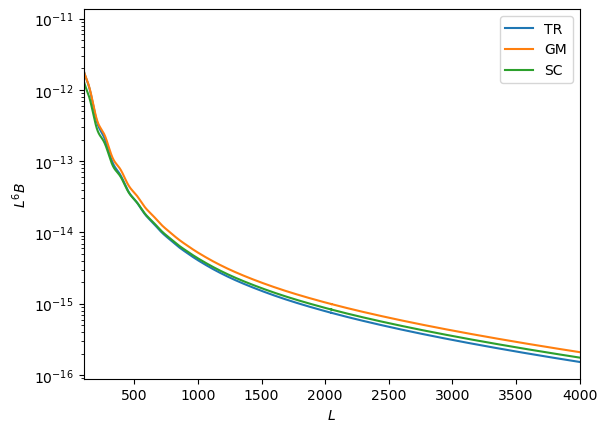

In [501]:
ls = np.arange(1, 4000)
models = ['TR', 'GM', 'SC']
for model in models:
    angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
    calculated = 8/(ls**3)**2*integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
    plt.plot(ls, calculated*ls**6, label = model)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(100, 4000)
plt.legend()
plt.ylabel('$L^6B$')
plt.xlabel('$L$')

In [502]:
import vegas

lmin, lmax = 1, 4000

integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi], [lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e3

values = []

def get_angle_12(L1, L2, L3):
    term = (L1**2+L2**2-L3**2)/(2*L1*L2)
    return np.arccos(term)

Rs = np.linspace(0.1, 6, 10)

models = ['TR', 'GM', 'SC']
results = {}
for model in models:
    values = []
    for R in Rs:

        Rdeg = R/60
        Rradians = np.deg2rad(Rdeg)
        sigma = Rradians / (2.0 * np.sqrt(2.0 * np.log(2.0)))
        WR = lambda l: np.exp(-(l*(l+1))/2*sigma**2)
        #WR = lambda l: np.exp(-l**2*Rradians**2/2)

        @vegas.batchintegrand
        def integrand(x):
            l, thetal = x[:, 0], x[:, 1]
            L, thetaL = x[:, 2], x[:, 3]

            lx, ly = np.cos(thetal)*l, np.sin(thetal)*l
            Lplx = L*np.cos(thetaL)+lx
            Lply = L*np.sin(thetaL)+ly
            Lplv = np.array([Lplx, Lply])
            Lpl = np.linalg.norm(Lplv, axis = 0)
            angle12 = get_angle_12(l, L, Lpl)
            angle13 = get_angle_12(l, Lpl, L)
            angle23 = get_angle_12(L, Lpl, l)
            value = L*l*WR(L)*WR(l)*WR(Lpl)*integrate_bispectrum_kkk(l, L, Lpl, angle12, angle13, angle23, model = model)
            return value/(2*np.pi)**2/(2*np.pi)**2

        result = integ(integrand, nitn = nitn, neval = neval)
        values += [result.mean]
        
    Rs, values = np.array(Rs), np.array(values)
    results[model] = values

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_55200/4190537223.py:12: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(term)
/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:277: AccuracyWarning: maxiter (50) exceeded. Latest difference = nan
  warnings.warn(


In [503]:
results_sims = np.load('results.npy', allow_pickle = True).take(0)
results_G_Born = np.load('resultsG.npy', allow_pickle = True).take(0)

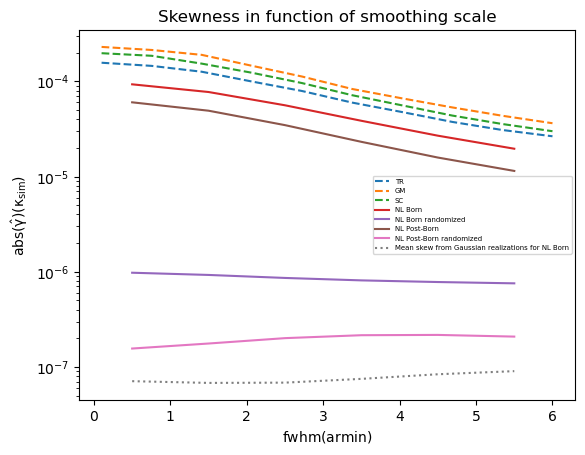

In [519]:
for k, values in results.items():
    plt.plot(Rs, abs(values), label = k, ls = '--')

fwhms = np.arange(0.5, 6, 1.)
plt.title('Skewness in function of smoothing scale')
for k in results_sims.keys():
    skews = np.array(results_sims[k])
    plt.plot(fwhms, abs(skews), label = k)

N = 2
meanskew = 0
for i in range(N):
    meanskew += np.array(results_G_Born[i])
meanskew /= N
plt.plot(fwhms, abs(meanskew), label = 'Mean skew from Gaussian realizations for NL Born', ls = ':')

plt.ylabel(r'$\rm{abs}(\hat{\gamma})(\kappa_{\rm{sim}})$')
plt.xlabel(r'$\rm{fwhm} (armin)$')

#plt.hlines(-1e-6, 0.5, 6, color = 'k', ls = '--', label = '-1e-6 line', alpha = 0.4)
plt.yscale('log')
plt.legend(fontsize = 5)
plt.savefig('empirical_skew_demuni.png', dpi = 300)

## Calculating $N^{3/2,\mathrm{cross}}$

In [474]:
import camb
import symlens as s
from pixell import enmap, utils as putils
import numpy as np

TCMB = 2.73e6

potential_file = "lensedCMB_dmn1_lenspotentialCls.dat"
d = np.loadtxt(f'/Users/omard/Documents/projects/fgcmblensing/input/giulio/{potential_file}')
l = d[:, 0]
lfact = 2*np.pi/l/(l+1)
unlensed = d[:, 1]
unlensed *= lfact**2#/TCMB**2.
ddlensing = d[:, 5]
kk = 2*np.pi*ddlensing/4
pp = 4/l**2/(l+1)**2*kk

TCMB = 2.73e6

dd = np.loadtxt('/Users/omard/Documents/projects/fgcmblensing/input/giulio/lensedCMB_dmn1_lensedgradCls.dat')

d = np.loadtxt('/Users/omard/Documents/projects/fgcmblensing/input/giulio/lensedCMB_dmn1_lensedCls.dat')
L, TT = d[:, 0], d[:, 1]
lensed = d[:, 1]
lfact = 2*np.pi/L/(L+1)
TT *= lfact#/TCMB**2.
lensed *= lfact

unlensed = np.interp(L, l, unlensed)



get_noise = lambda x, level, theta: (level*np.pi/180/60)**2*np.exp(x*(x+1)*np.deg2rad(theta / 60)**2/8/np.log(2))

shape,wcs = enmap.geometry(shape=(512,512),res=2.0*putils.arcmin,pos=(0,0))

modlmap = enmap.modlmap(shape,wcs)

f = s.Ldl1 * s.e('uC_T_T_l1') + s.Ldl2 * s.e('uC_T_T_l2')

F = f / 2 / s.e('tC_T_T_l1') / s.e('tC_T_T_l2')

expr1 = f * F

fsky = 0.4
noise, beam = 1., 1.

feed_dict = {}
feed_dict['uC_T_T'] = s.interp(L,TT)(modlmap)
feed_dict['tC_T_T'] = s.interp(L,TT)(modlmap)+s.interp(L,get_noise(L, noise, beam))(modlmap)

tellmin = 10
tellmax = 3000
xmask = s.mask_kspace(shape,wcs,lmin=tellmin,lmax=tellmax)
integral = s.integrate(shape,wcs,feed_dict,expr1,xmask=xmask,ymask=xmask).real
Alkappa = modlmap**4*1/integral/4

AlkappaR = s.A_l(shape,wcs,feed_dict,"hu_ok","TT",xmask=xmask,ymask=xmask)

bin_edges = np.arange(1,4000,20)
binner = s.bin2D(modlmap,bin_edges)
A_l = Alkappa

cents, ALR1D = binner.bin(AlkappaR)

cents, AL1D = binner.bin(A_l)

Nl = s.N_l_from_A_l_optimal(shape,wcs,AlkappaR)
cents, Nl1D = binner.bin(Nl)

expr = integral
cents, expr1D = binner.bin(expr)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_55200/2565879204.py:56: RuntimeWarning: invalid value encountered in divide
  Alkappa = modlmap**4*1/integral/4
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]
/Users/omard/Documents/projects/symlens/symlens/qe.py:748: RuntimeWarning: overflow encountered in multiply
  return Al * modlmap*(modlmap+1.)/4.
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


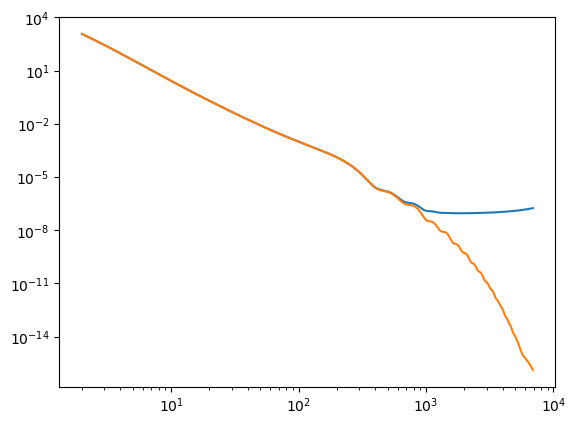

In [475]:
plt.loglog(L, lensed+get_noise(L, noise, beam))
plt.loglog(L, unlensed)


In [476]:
lmin, lmax = tellmin, tellmax
selection = (L >= lmin) & (L <= lmax)

In [479]:
import scipy as sp

uTT = sp.interpolate.interp1d(L[selection], unlensed[selection], fill_value = 0., bounds_error = False)
lTT = sp.interpolate.interp1d(L[selection], lensed[selection], fill_value = 0., bounds_error = False)
tTT = sp.interpolate.interp1d(L[selection], lensed[selection]+get_noise(L, noise, beam)[selection], fill_value = 1e20, bounds_error = False)

In [480]:
def dot(a, b):
    return np.einsum('ab, ab -> b', a, b)

def fTT(l1v, l2v, l1n, l2n):
    return np.dot(l1v+l2v, l1v)*lTT(l1n)+np.dot(l1v+l2v, l2v)*lTT(l2n)

def ftotTT(l):
    return tTT(l)

def g(lv, Lv):
    l1v, l2v = lv, Lv-lv
    l1n, l2n = np.linalg.norm(l1v), np.linalg.norm(l2v)
    return fTT(l1v, l2v, l1n, l2n)/(2*ftotTT(l1n)*ftotTT(l2n))

In [481]:
Ls = np.arange(5, 1000, 10)

In [482]:
import vegas

lmin, lmax = 1, 4000

integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e2
    

In [483]:
Rs = {}
names = ['par', 'perp']
result_temps = {n: [] for n in names}
for L in Ls:
    Lvec = np.array([L, 0])
    def integrand(x):
            l, theta = x 
            common = g(np.array([l*np.cos(theta), l*np.sin(theta)]), Lvec)*uTT(l)*l**2*l
            return [common*f(theta)**2 for f in [np.cos, np.sin]]
    result = integ(integrand, nitn = nitn, neval = neval)
    [result_temps[n].append(result[i].mean) for i, n in enumerate(names)]
Rs = {n: np.array(result_temps[n])/(2*np.pi)**2 for n in names}

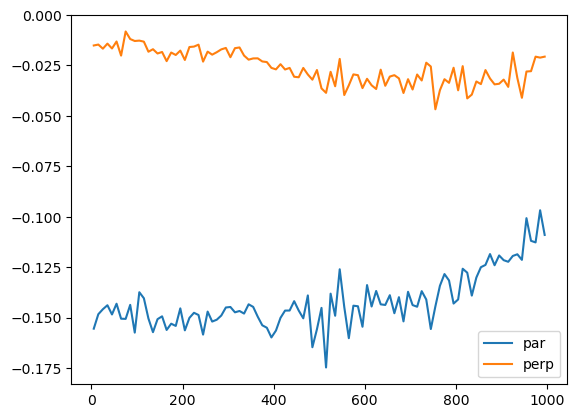

In [484]:
for n in names:
    plt.plot(Ls, Rs[n]*1/Ls**2*1e-11, label = n)
plt.legend()

In [485]:
model = 'TR'

In [486]:
lmin, lmax = 1, 4000
integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e2

In [487]:
betas = {}
bparf = lambda l, theta, L: np.cos(theta)*(l*np.cos(theta)-L)*l
bperpf = lambda l, theta, L: np.sin(theta)**2*l**2


result_temps = {n: [] for n in names}
for L in Ls:
    Lvec = np.array([L, 0])

    def integrand(x):
        l, theta = x
        Lmlv = np.array([L-l*np.cos(theta), -l*np.sin(theta)])
        Lml = np.linalg.norm(Lmlv)
        angle12 = get_angle_12(l, -L, Lml)
        angle13 = get_angle_12(l, Lml, -L)
        angle23 = get_angle_12(-L, Lml, l)
        angle12, angle13, angle23 = np.nan_to_num(angle12), np.nan_to_num(angle13), np.nan_to_num(angle23)
        factortophi = -8/(l*L*Lml)**2
        common = factortophi*integrate_bispectrum_kkk(l, Lml, L, angle12, angle13, angle23, model = model)*l
        return [f(l, theta, L)*common for f in [bparf, bperpf]]

    result = integ(integrand, nitn = nitn, neval = neval)
    [result_temps[n].append(result[i].mean) for i, n in enumerate(names)]
betas = {n: np.array(result_temps[n])/(2*np.pi)**2 for n in names}

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_55200/135368975.py:12: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(term)


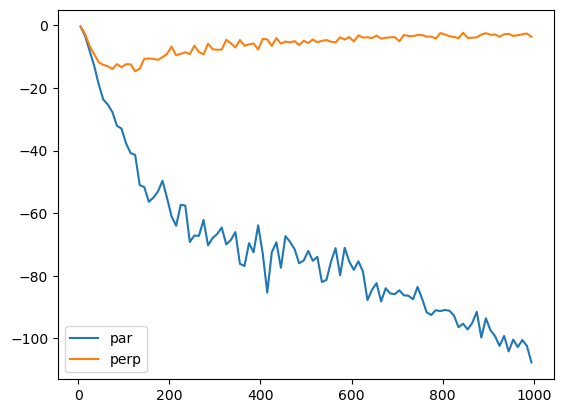

In [488]:
for n in names:
    plt.plot(Ls, betas[n]*Ls**4*1e10, label = n)
plt.legend()

In [489]:
integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e3

def SfTT(l1v, l2v, l1n, l2n):
    return np.dot(l1v+l2v, l1v)*lTT(l1n)+np.dot(l1v+l2v, l2v)*lTT(l2n)

def SftotTT(l):
    return tTT(l)

def Sg(lv, Lv):
    l1v, l2v = lv, Lv-lv
    l1n, l2n = np.linalg.norm(l1v), np.linalg.norm(l2v)
    return SfTT(l1v, l2v, l1n, l2n)/(2*SftotTT(l1n)*SftotTT(l2n))

S = []
for L in Ls:
    Lvec = np.array([L, 0])
    def integrand(x):
        l, theta = x
        ldotL = L*l*np.cos(theta)
        result = Sg(np.array([l*np.cos(theta), l*np.sin(theta)]), Lvec)*uTT(l)*ldotL*l
        return result
    result = integ(integrand, nitn = nitn, neval = neval)
    S.append(result.mean)
S = np.array(S)/(2*np.pi)**2


In [490]:
AL = np.interp(Ls, cents, AL1D)

In [491]:
ALnew = np.interp(Ls, cents, expr1D**-1)

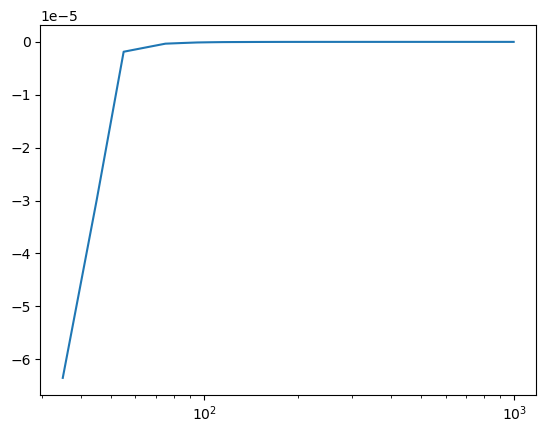

In [494]:
ppinterp = np.interp(Ls, l, ddlensing)
NC1term = -4*ALnew**2*S*np.sum([betas[n]*Rs[n] for n in names], axis = 0)
plt.plot(Ls, NC1term/ppinterp)
plt.xscale('log')

In [493]:
def dot_(a, b):
    return np.einsum('ab, ab -> b', a, b)

def dot(a, b):
    return a[0, :]*b[0, :]+a[1, :]*b[1, :]

    
def fTTbatch(l1v, l2v, l1n, l2n):
    return dot(l1v+l2v, l1v)*lTT(l1n)+dot(l1v+l2v, l2v)*lTT(l2n)

def ftotTTfTTbatch(l):
    return tTT(l)

def gfTTbatch(lv, Lv, l1n, l2n):
    l1v, l2v = lv, Lv-lv
    return fTTbatch(l1v, l2v, l1n, l2n)/(2*ftotTTfTTbatch(l1n)*ftotTTfTTbatch(l2n))

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline
lmin=2

cTTobs = InterpolatedUnivariateSpline(ls,CT[2:lmax+1,0]/ls/(ls+1)*2*np.pi + noise)
cTTgrad_obs = InterpolatedUnivariateSpline(ls,clgrad[2:lmax+1,0]/ls/(ls+1)*2*np.pi + noise)

def get_response(lmaxTT = 4000):
    Nzero = np.zeros(Ls.shape)
    resp = np.zeros(Ls.shape)
    resp_grad = np.zeros(Ls.shape)
    resp_gradgrad = np.zeros(Ls.shape)
    resp_gradgradgrad = np.zeros(Ls.shape)    
    dL = 5
    for ix, L in enumerate(Ls):
        Lsamp=  np.arange(lmin,lmaxTT+1, dL, dtype=np.float64)
        resp_L = np.zeros(Lsamp.shape)
        resp_grad_L = np.zeros(Lsamp.shape)
        resp_gradgrad_L = np.zeros(Lsamp.shape)
        resp_gradgradgrad_L = np.zeros(Lsamp.shape)        
        for i, l in enumerate(Lsamp):
            nphi= max(32,2*int(l)+1) 
            nphi=min(nphi,128) 
            dphi=(2*np.pi/nphi)
            phi = np.linspace(0,2*np.pi, nphi, endpoint =False)
            cos = np.cos(phi)
            weight = dphi*l/(2*np.pi)**2 
            l3 = np.sqrt(L**2+l**2 -2*L*l*cos)

            response =((-L*l*cos + L**2)*cTT(l3) + (L*l*cos)*cTT(l))  
            response_grad =((-L*l*cos + L**2)*cTTgrad(l3) + (L*l*cos)*cTTgrad(l))
            
            filter = 1/(cTTobs(l)*cTTobs(l3))
            filter[l3<lmin]=0
            filter[l3>lmaxTT]=0
            
            filter_grad = 1/(cTTgrad_obs(l)*cTTgrad_obs(l3))            
            #filter_grad = 1/(cTTobs(l)*cTTobs(l3))
            filter_grad[l3<lmin]=0
            filter_grad[l<lmin]=0            
            filter_grad[l3>lmaxTT]=0
            
            g = response*filter
            g_grad = response*filter_grad             
            g_gradgrad = response_grad*filter
            
            resp_L[i] = np.dot(g,response)*weight   
            resp_grad_L[i] = np.dot(g,response_grad)*weight   
            resp_gradgrad_L[i] = np.dot(g_grad,response_grad)*weight  
            resp_gradgradgrad_L[i] = np.dot(g_gradgrad,response_grad)*weight            
            
        resp[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))
        resp_grad[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_grad_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))
        resp_gradgrad[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_gradgrad_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))
        resp_gradgradgrad[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_gradgradgrad_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))        
        
    return resp, resp_grad, resp_gradgrad,resp_gradgradgrad
lmaxTT=lmax
print '%s lmaxTT = %d lmax =%d'%(experiment,lmaxTT,lmax),lmaxTT,lmax
#resp, resp_grad = get_response(lmaxTT)
resp, resp_grad, resp_gradgrad, resp_gradgradgrad = get_response(lmaxTT=4000)


In [426]:
integ = vegas.Integrator([[lmin, lmax], [lmin, lmax], [0, 2*np.pi], [0, 2*np.pi]])
nitn, neval = 10, 1e2

NA1 = []
for L in Ls:

    @vegas.batchintegrand
    def integrand(x):
        l, l1, theta, theta1 = x.T
        lv, l1v = np.array([l*np.cos(theta), l*np.sin(theta)]), np.array([l1*np.cos(theta1), l1*np.sin(theta1)])
        Lvec = np.c_[np.ones_like(l)*L, np.zeros_like(l)].T
        l1ml = l1v-lv
        l1mln = np.linalg.norm(l1ml, axis = 0)
        l1mldotl = (l1ml[0, :]*lv[0, :]+l1ml[1, :]*lv[1, :])/(l1mln*l)
        Lmlv = Lvec-lv
        Lmln = np.linalg.norm(Lmlv, axis = 0)

        Lmldotl1ml = (Lmlv[0, :]*l1ml[0, :]+Lmlv[1, :]*l1ml[1, :])/(Lmln*l1mln)
        temp = uTT(l1mln)

        l2n = np.linalg.norm(Lvec-l1v, axis = 0)
        product = l1mldotl*Lmldotl1ml*temp*gfTTbatch(l1v, Lvec, l1, l2n)

        Lml = np.linalg.norm(Lmlv)
        angle12 = get_angle_12(l, -L, Lml)
        angle13 = get_angle_12(l, Lml, -L)
        angle23 = get_angle_12(-L, Lml, l)
        angle12, angle13, angle23 = np.nan_to_num(angle12), np.nan_to_num(angle13), np.nan_to_num(angle23)
        factortophi = -8/(l*L*Lml)**2
        return factortophi*integrate_bispectrum_kkk(l, Lml, L, angle12, angle13, angle23, model = model)*product*l*l1
    result = integ(integrand, nitn = nitn, neval = neval)
    NA1 += [result.mean]
NA1 = np.array(NA1)/(2*np.pi)**4

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_55200/135368975.py:12: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(term)


In [436]:
integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi], [lmin, lmax], [0, 2*np.pi]])
nitn, neval = 10, 1e2
 
NC1 = []
for L in Ls:

    @vegas.batchintegrand
    def integrand(x):
        l1, theta1, l, theta = x.T
        lv, l1v = np.array([l*np.cos(theta), l*np.sin(theta)]), np.array([l1*np.cos(theta1), l1*np.sin(theta1)])
        Lvec = np.c_[np.ones_like(l)*L, np.zeros_like(l)].T

        l1dotl = (l1v[0, :]*lv[0, :]+l1v[1, :]*lv[1, :])/(l1*l)

        Lmlv = Lvec-lv
        Lmln = np.linalg.norm(Lmlv, axis = 0)

        l1dotLml = (Lmlv[0, :]*l1v[0, :]+Lmlv[1, :]*l1v[1, :])/(Lmln*l1)

        l2n = np.linalg.norm(Lvec-l1v, axis = 0)
        product = l1dotl*l1dotLml*uTT(l1)*gfTTbatch(l1v, Lvec, l1, l2n)

        Lml = Lmln
        angle12 = get_angle_12(l, Lml, -L)
        angle13 = get_angle_12(l, -L, Lml)
        angle23 = get_angle_12(-L, Lml, l)
        angle12, angle13, angle23 = np.nan_to_num(angle12), np.nan_to_num(angle13), np.nan_to_num(angle23)
        angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
        factortophi = -8/(l*L*Lml)**2
        return factortophi*integrate_bispectrum_kkk(l, Lml, L, angle12, angle13, angle23, model = model)*product*l*l1
    result = integ(integrand, nitn = nitn, neval = neval)
    NC1 += [result.mean]
NC1 = np.array(NC1)/(2*np.pi)**4

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_55200/135368975.py:12: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(term)


KeyboardInterrupt: 

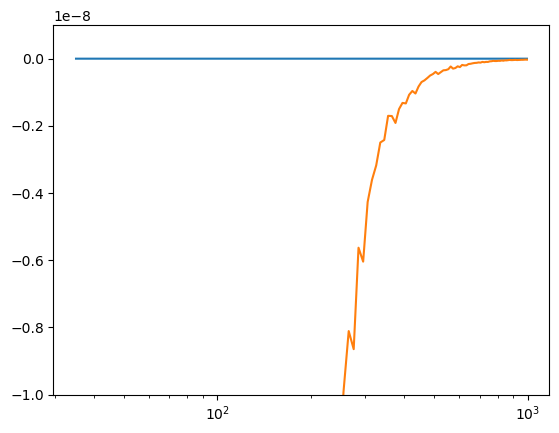

In [ ]:
NC1term_alt = 4*ALnew**2*S*NC1
plt.plot(Ls, NC1term_alt/ppinterp)
plt.plot(Ls, NC1term/ppinterp)
plt.ylim(-1e-8, 1e-9)
plt.xscale('log')

In [358]:
NA1term = -4*ALnew**2*S*NA1

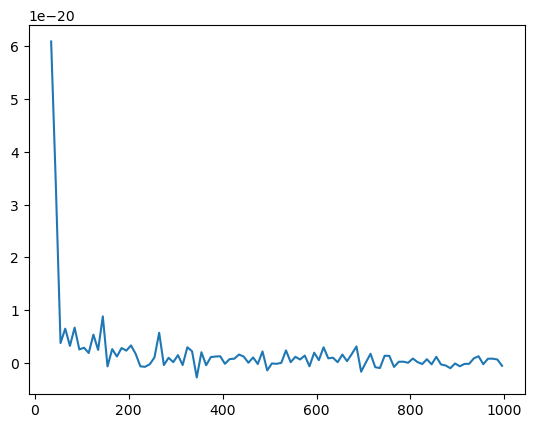

In [359]:
plt.plot(Ls, NA1term*Ls**4/(2*np.pi))